In [37]:

import requests
import pandas as pd
from tqdm import tqdm
import os
from dotenv import load_dotenv

CSV_PATH = "bay_area_yelp_businesses.csv"


load_dotenv()

headers = {
    "Authorization": f"Bearer {os.getenv('YELP_API_KEY')}"
}


def yelp_search(location, categories=None, zip_code=None, limit=50, offset=0):
    url = "https://api.yelp.com/v3/businesses/search"
    
    params = {
        "location": location,
        "limit": limit,
        "offset": offset
    }
    
    if categories:
        params["categories"] = categories
    
    if zip_code:
        params["location"] = zip_code
    
    response = requests.get(url, headers=headers, params=params)
    return response.json()


def collect_zip_businesses(zip_code, categories_list, max_results=200):
    """
    Pull multiple categories for a single ZIP code.
    categories_list: ["cafes", "bubbletea", "matcha", ...]
    max_results: total limit per category
    """
    all_rows = []

    for cat in categories_list:
        for offset in range(0, max_results, 50):  # Yelp limit = 50 per request
            data = yelp_search(location=zip_code, categories=cat, offset=offset)
            businesses = data.get("businesses", [])
            if not businesses:
                break

            for b in businesses:
                all_rows.append({
                    "zip": zip_code,
                    "name": b.get("name"),
                    "rating": b.get("rating"),
                    "review_count": b.get("review_count"),
                    "price": b.get("price", None),
                    "lat": b["coordinates"]["latitude"] if "coordinates" in b else None,
                    "lon": b["coordinates"]["longitude"] if "coordinates" in b else None,
                    "categories": ", ".join([c["title"] for c in b.get("categories", [])]),
                    "main_category": cat
                })

    return pd.DataFrame(all_rows)


bay_area_zips = [
    "94110", "94117", "94103", "94109",  # SF
    "94607", "94612", "94606",          # Oakland
    "94704", "94709",                   # Berkeley
    "95112", "95126"                    # San Jose
]

# Basic trendy categories
trendy_categories = [
    "matcha", "bubbletea", "cafes", "coffee", 
    "newamerican", "vegan", "poke", 
    "cocktailbars", "desserts", "pilates"
]


if os.path.exists(CSV_PATH):
    print(f"CSV file '{CSV_PATH}' exists. Skipping Yelp data collection.")
    yelp_df = pd.read_csv(CSV_PATH)
else:
    all_dfs = []

    print("Pulling Yelp business data...")
    for z in tqdm(bay_area_zips):
        df_zip = collect_zip_businesses(z, trendy_categories)
        all_dfs.append(df_zip)

    yelp_df = pd.concat(all_dfs, ignore_index=True)

    yelp_df.to_csv(CSV_PATH, index=False)

yelp_df.head()


CSV file 'bay_area_yelp_businesses.csv' exists. Skipping Yelp data collection.


,zip,name,rating,review_count,price,lat,lon,categories,main_category
0,94110,Lazy Bear,4.4,878,$$$$,37.760410,-122.419690,New American,matcha
1,94110,Foreign Cinema,4.0,5786,$$$,37.756370,-122.419250,"Breakfast & Brunch, Mediterranean, Cocktail Bars",matcha
2,94110,Shizen,4.5,2799,$$$,37.768310,-122.421667,"Sushi Bars, Vegan, Izakaya",matcha
3,94110,Beretta Valencia,4.0,4301,$$,37.753856,-122.420628,"Italian, Pizza, Breakfast & Brunch",matcha
4,94110,Lolinda,4.2,2566,$$$,37.756697,-122.419079,"Steakhouses, Tapas/Small Plates, Latin American",matcha


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import Counter

matplotlib.rcParams['axes.formatter.use_mathtext'] = False

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

df = pd.read_csv("bay_area_yelp_businesses.csv")

print("=" * 60)
print("BASIC DATA OVERVIEW")
print("=" * 60)
print(f"Total businesses: {len(df):,}")
print(f"Unique ZIP codes: {df['zip'].nunique()}")
print(f"ZIP codes: {sorted(df['zip'].unique())}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nData types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head(10)


BASIC DATA OVERVIEW
Total businesses: 12,123
Unique ZIP codes: 11
ZIP codes: [np.int64(94103), np.int64(94109), np.int64(94110), np.int64(94117), np.int64(94606), np.int64(94607), np.int64(94612), np.int64(94704), np.int64(94709), np.int64(95112), np.int64(95126)]

Columns: ['zip', 'name', 'rating', 'review_count', 'price', 'lat', 'lon', 'categories', 'main_category']

Missing values:
zip                 0
name                0
rating              0
review_count        0
price            4035
lat                18
lon                18
categories          1
main_category       0
dtype: int64

Data types:
zip                int64
name              object
rating           float64
review_count       int64
price             object
lat              float64
lon              float64
categories        object
main_category     object
dtype: object

First few rows:


,zip,name,rating,review_count,price,lat,lon,categories,main_category
0,94110,Lazy Bear,4.4,878,$$$$,37.760410,-122.419690,New American,matcha
1,94110,Foreign Cinema,4.0,5786,$$$,37.756370,-122.419250,"Breakfast & Brunch, Mediterranean, Cocktail Bars",matcha
2,94110,Shizen,4.5,2799,$$$,37.768310,-122.421667,"Sushi Bars, Vegan, Izakaya",matcha
3,94110,Beretta Valencia,4.0,4301,$$,37.753856,-122.420628,"Italian, Pizza, Breakfast & Brunch",matcha
4,94110,Lolinda,4.2,2566,$$$,37.756697,-122.419079,"Steakhouses, Tapas/Small Plates, Latin American",matcha
5,94110,San Ho Won,4.6,840,$$$$,37.759596,-122.410247,"Korean, Barbeque",matcha
6,94110,Taishoken San Francisco,4.5,544,$$,37.762219,-122.421506,"Ramen, Noodles, Izakaya",matcha
7,94110,Loló,4.2,2573,$$,37.757390,-122.421476,"Mexican, Tapas/Small Plates",matcha
8,94110,Ernest,4.3,608,$$$,37.763177,-122.410949,"New American, Seafood, Bars",matcha
9,94110,El Farolito,4.2,5688,$,37.752650,-122.418120,Mexican,matcha


In [39]:
# Define  keywords that indicate gentrification
HIP_KEYWORDS = [
    'artisanal', 'craft', 'fusion', 'minimalist', 'matcha', 
    'third wave', 'boutique', 'curated', 'specialty', 'gourmet',
    'farm-to-table', 'organic', 'sustainable', 'locally sourced',
    'small batch', 'handcrafted', 'bespoke', 'elevated'
]

# Define trendy/gentrified categories
TRENDY_CATEGORIES = [
    'New American', 'Vegan', 'Coffee & Tea', 'Cocktail Bars',
    'Matcha', 'Bubble Tea', 'Poke', 'Pilates', 'Yoga',
    'Wine Bars', 'Tapas', 'Izakaya', 'Gastropubs',
    'Artisanal', 'Specialty', 'Third Wave Coffee'
]

# Define high-end price indicators
HIGH_END_PRICE = ['$$$', '$$$$']

def is_gentrified_business(row):
    """
    Classify a business as gentrified based on multiple indicators.
    Returns a score and boolean classification.
    """
    score = 0
    indicators = []
    
    if pd.notna(row['price']) and row['price'] in HIGH_END_PRICE:
        score += 3
        indicators.append('high_price')
    
    categories_str = str(row['categories']).lower()
    for cat in TRENDY_CATEGORIES:
        if cat.lower() in categories_str:
            score += 2
            indicators.append(f'category_{cat.lower().replace(" ", "_")}')
            break  # Count each category only once
    
    name_cat_str = (str(row['name']) + ' ' + str(row['categories'])).lower()
    for keyword in HIP_KEYWORDS:
        if keyword in name_cat_str:
            score += 1
            indicators.append(f'keyword_{keyword}')
    
    if pd.notna(row['rating']) and row['rating'] >= 4.5:
        if pd.notna(row['review_count']) and row['review_count'] >= 500:
            score += 1
            indicators.append('high_rating_reviews')
    
    trendy_main_cats = ['matcha', 'bubbletea', 'newamerican', 'vegan', 'poke', 'pilates']
    if str(row['main_category']).lower() in trendy_main_cats:
        score += 1
        indicators.append('trendy_main_category')
    
    is_gentrified = score >= 3
    
    return pd.Series({
        'gentrification_score': score,
        'is_gentrified': is_gentrified,
        'indicators': ', '.join(indicators) if indicators else 'none'
    })

print("Classifying businesses as gentrified...")
gentrification_results = df.apply(is_gentrified_business, axis=1)
df['gentrification_score'] = gentrification_results['gentrification_score']
df['is_gentrified'] = gentrification_results['is_gentrified']
df['gentrification_indicators'] = gentrification_results['indicators']

print(f"\nClassification complete!")
print(f"Gentrified businesses: {df['is_gentrified'].sum():,} ({df['is_gentrified'].mean()*100:.1f}%)")
print(f"Non-gentrified businesses: {(~df['is_gentrified']).sum():,} ({(~df['is_gentrified']).mean()*100:.1f}%)")


Classifying businesses as gentrified...

Classification complete!
Gentrified businesses: 5,519 (45.5%)
Non-gentrified businesses: 6,604 (54.5%)


In [40]:
zip_stats = df.groupby('zip').agg({
    'is_gentrified': ['sum', 'mean', 'count'],
    'gentrification_score': 'mean',
    'price': lambda x: (x.isin(['$$$', '$$$$']).sum()),
    'rating': 'mean',
    'review_count': 'mean'
}).round(2)

zip_stats.columns = ['gentrified_count', 'gentrified_pct', 'total_businesses', 
                     'avg_gentrification_score', 'high_price_count', 
                     'avg_rating', 'avg_review_count']
zip_stats = zip_stats.sort_values('gentrified_pct', ascending=False)

print("=" * 60)
print("GENTRIFICATION STATISTICS BY ZIP CODE")
print("=" * 60)
print(zip_stats)

city_labels = {
    '94110': 'SF - Mission',
    '94117': 'SF - Castro',
    '94103': 'SF - SOMA',
    '94109': 'SF - North Beach',
    '94607': 'Oakland - West',
    '94612': 'Oakland - Downtown',
    '94606': 'Oakland - East',
    '94704': 'Berkeley - South',
    '94709': 'Berkeley - North',
    '95112': 'San Jose - Downtown',
    '95126': 'San Jose - Rose Garden'
}

zip_stats['city'] = zip_stats.index.map(city_labels)
zip_stats


GENTRIFICATION STATISTICS BY ZIP CODE
       gentrified_count  gentrified_pct  total_businesses  \
zip                                                         
94117               749            0.59              1262   
94110               527            0.56               938   
94709               342            0.52               652   
94103               604            0.45              1344   
94612               497            0.45              1110   
94606               464            0.44              1051   
94109               521            0.43              1207   
94607               594            0.42              1426   
95126               500            0.42              1184   
95112               444            0.40              1119   
94704               277            0.33               830   

       avg_gentrification_score  high_price_count  avg_rating  \
zip                                                             
94117                      2.73       

,gentrified_count,gentrified_pct,total_businesses,avg_gentrification_score,high_price_count,avg_rating,avg_review_count,city
zip,,,,,,,,
94117,749,0.59,1262,2.73,164,3.91,552.73,NaN
94110,527,0.56,938,2.52,70,3.93,494.94,NaN
94709,342,0.52,652,2.25,11,3.93,373.94,NaN
94103,604,0.45,1344,2.38,192,3.86,610.42,NaN
94612,497,0.45,1110,2.12,36,3.92,332.96,NaN
94606,464,0.44,1051,2.11,34,3.87,321.37,NaN
94109,521,0.43,1207,2.39,178,3.84,618.27,NaN
94607,594,0.42,1426,2.10,75,4.00,379.84,NaN
95126,500,0.42,1184,2.05,51,3.89,498.69,NaN


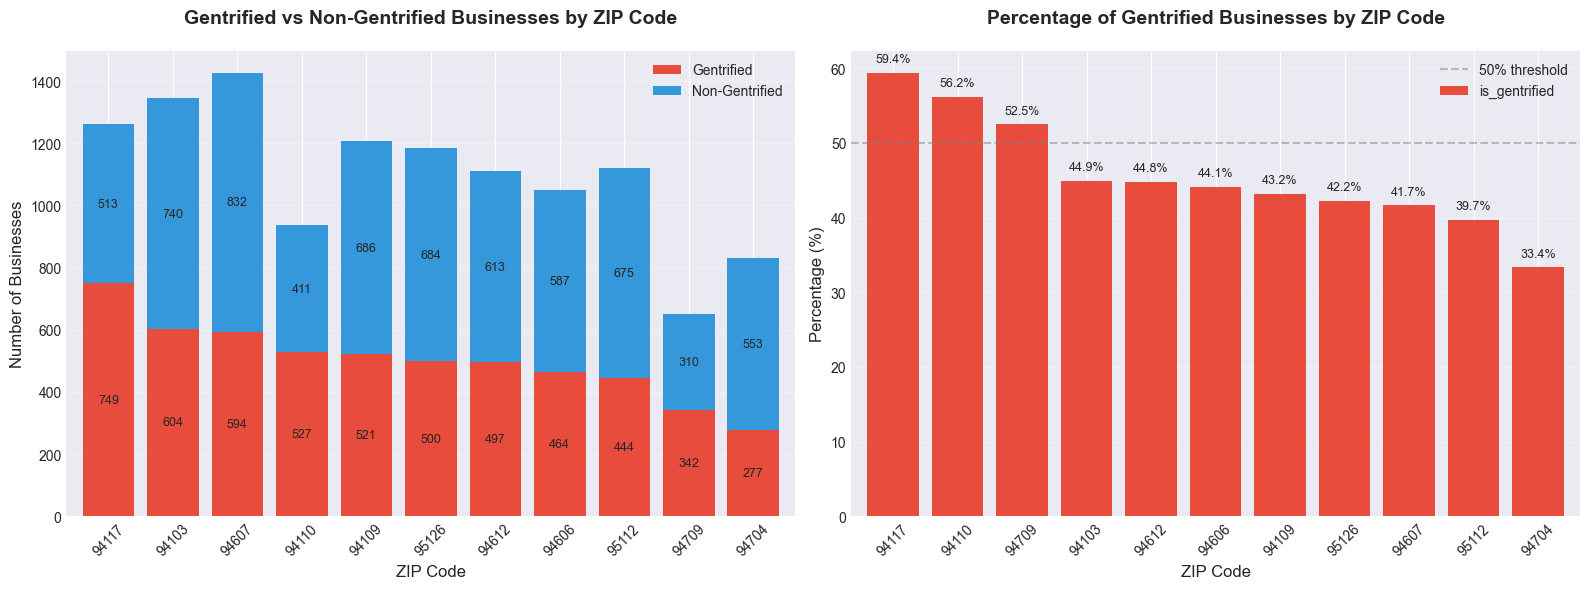


Total Gentrified Businesses: 5,519
Total Non-Gentrified Businesses: 6,604
Overall Gentrification Rate: 45.5%


In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Count of gentrified businesses by ZIP
zip_counts = df.groupby('zip')['is_gentrified'].agg(['sum', 'count'])
zip_counts.columns = ['Gentrified', 'Total']
zip_counts = zip_counts.sort_values('Gentrified', ascending=False)
zip_counts['Non-Gentrified'] = zip_counts['Total'] - zip_counts['Gentrified']

ax1 = zip_counts[['Gentrified', 'Non-Gentrified']].plot(
    kind='bar', stacked=True, ax=axes[0], 
    color=['#e74c3c', '#3498db'], width=0.8
)
axes[0].set_title('Gentrified vs Non-Gentrified Businesses by ZIP Code', 
                  fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('ZIP Code', fontsize=12)
axes[0].set_ylabel('Number of Businesses', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', label_type='center', fontsize=9)

# Plot 2: Percentage of gentrified businesses by ZIP
zip_pct = df.groupby('zip')['is_gentrified'].mean() * 100
zip_pct = zip_pct.sort_values(ascending=False)

ax2 = zip_pct.plot(kind='bar', ax=axes[1], color='#e74c3c', width=0.8)
axes[1].set_title('Percentage of Gentrified Businesses by ZIP Code', 
                  fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('ZIP Code', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
axes[1].legend()

# Add percentage labels on bars
for i, v in enumerate(zip_pct):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('gentrification_by_zip.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal Gentrified Businesses: {df['is_gentrified'].sum():,}")
print(f"Total Non-Gentrified Businesses: {(~df['is_gentrified']).sum():,}")
print(f"Overall Gentrification Rate: {df['is_gentrified'].mean()*100:.1f}%")


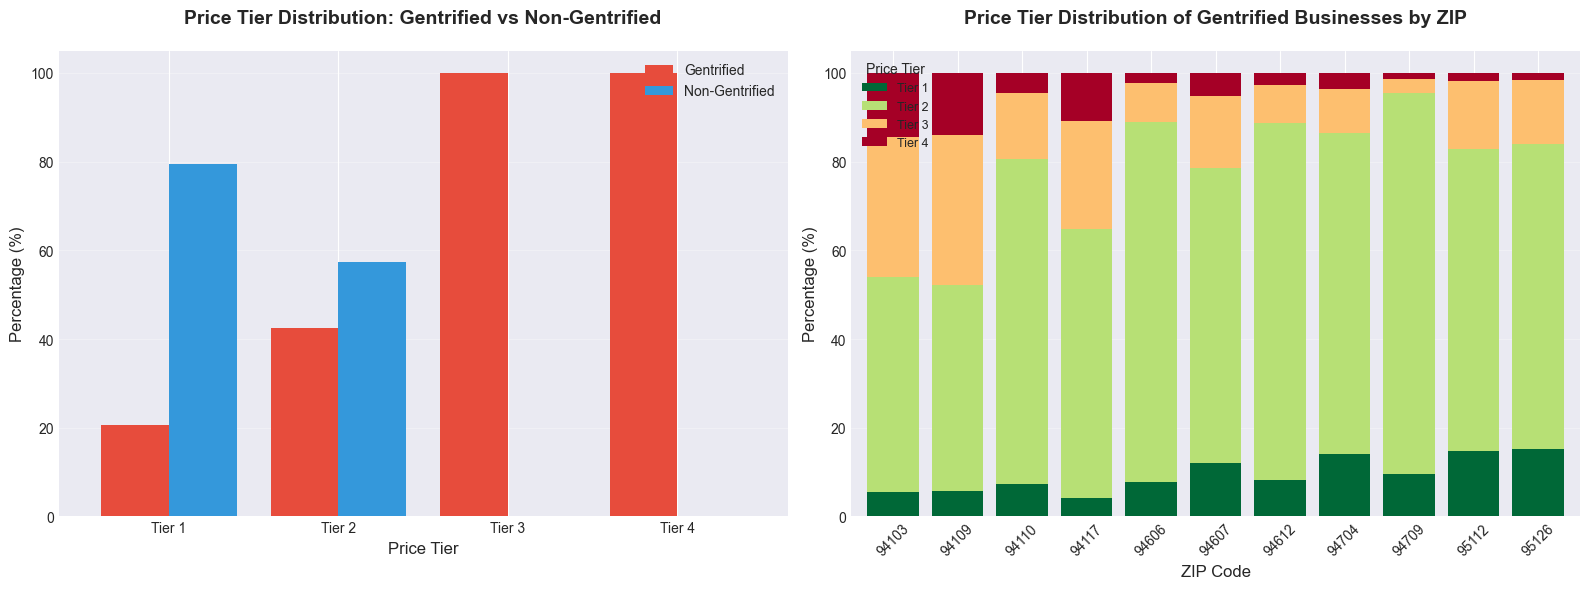


Price Tier Summary for Gentrified Businesses:
price
$        318
$$      2408
$$$      651
$$$$     232
Name: count, dtype: int64


In [42]:

price_label_map = {
    '$': 'Tier 1',
    '$$': 'Tier 2',
    '$$$': 'Tier 3',
    '$$$$': 'Tier 4'
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Price tier distribution for gentrified vs non-gentrified
price_gentrified = df[df['is_gentrified'] == True]['price'].value_counts().sort_index()
price_non_gentrified = df[df['is_gentrified'] == False]['price'].value_counts().sort_index()

price_comparison = pd.DataFrame({
    'Gentrified': price_gentrified,
    'Non-Gentrified': price_non_gentrified
}).fillna(0)

# Normalize to percentages
price_comparison_pct = price_comparison.div(price_comparison.sum(axis=1), axis=0) * 100

# Create display labels (use numeric tier labels to avoid $ parsing)
display_labels = [price_label_map.get(str(idx), str(idx)) for idx in price_comparison_pct.index]

ax1 = price_comparison_pct.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#3498db'], width=0.8)
axes[0].set_xticklabels(display_labels, rotation=0)
axes[0].set_title('Price Tier Distribution: Gentrified vs Non-Gentrified', 
                  fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Price Tier', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Price tier by ZIP code (gentrified only)
gentrified_df = df[df['is_gentrified'] == True]
price_by_zip = pd.crosstab(gentrified_df['zip'], gentrified_df['price'], normalize='index') * 100
price_by_zip = price_by_zip.sort_index(axis=1)  # Sort price columns

# Rename columns for display (use safe labels)
price_by_zip_display = price_by_zip.copy()
price_by_zip_display.columns = [price_label_map.get(str(col), str(col)) for col in price_by_zip_display.columns]

ax2 = price_by_zip_display.plot(kind='bar', stacked=True, ax=axes[1], 
                        colormap='RdYlGn_r', width=0.8)
axes[1].set_title('Price Tier Distribution of Gentrified Businesses by ZIP', 
                  fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('ZIP Code', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Price Tier', loc='upper left', fontsize=9)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('price_tier_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPrice Tier Summary for Gentrified Businesses:")
print(gentrified_df['price'].value_counts().sort_index())


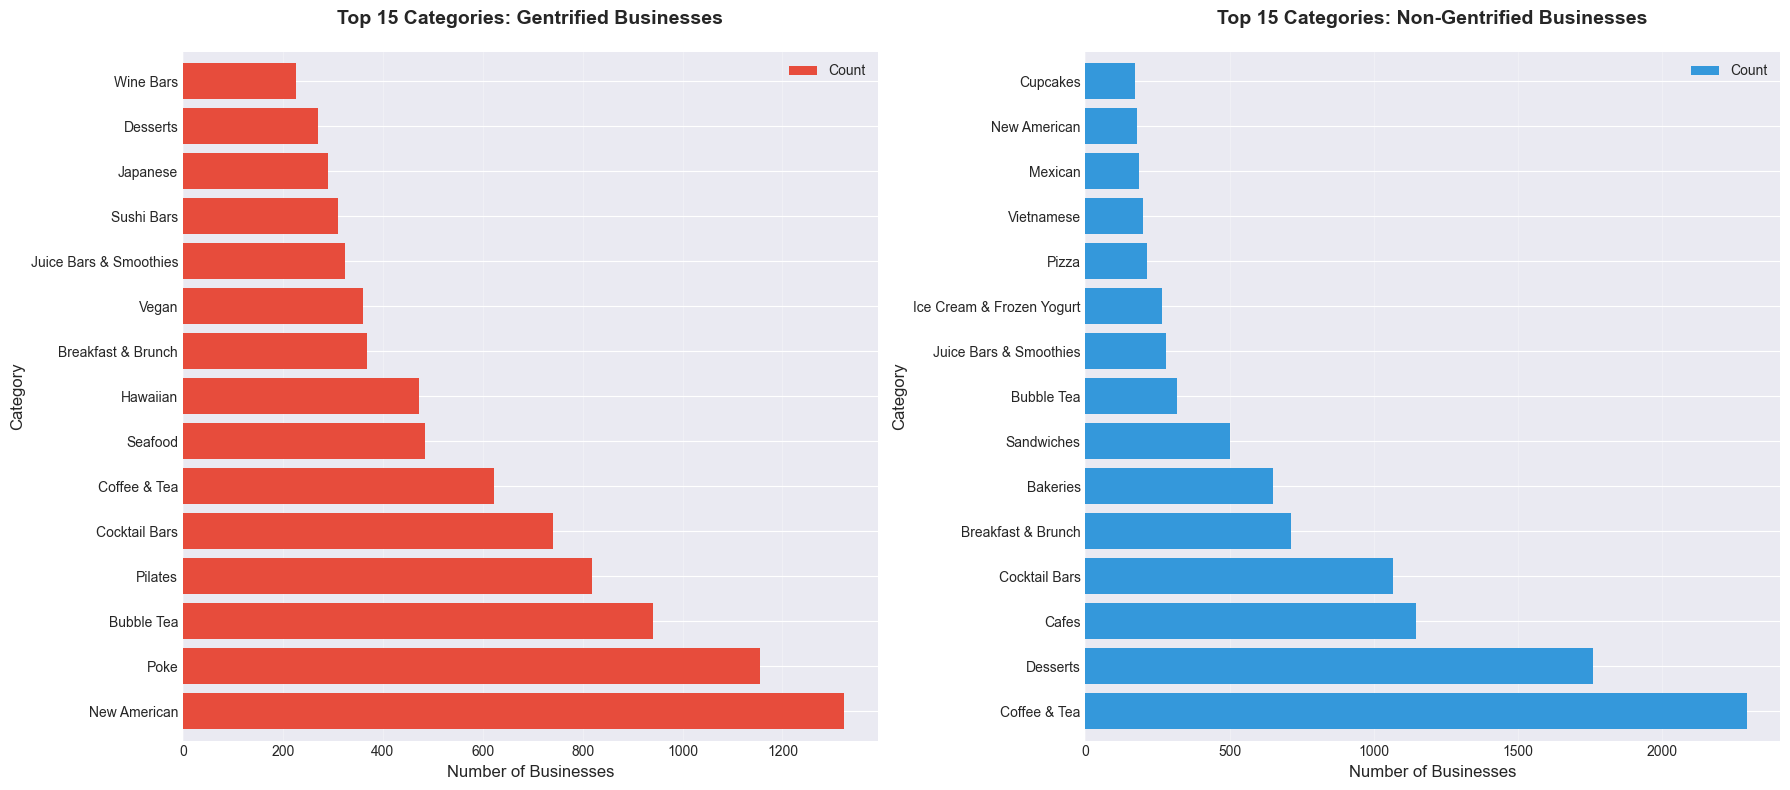


Total unique categories (gentrified): 223
Total unique categories (non-gentrified): 252


In [43]:

def extract_categories(cat_string):
    if pd.isna(cat_string):
        return []
    return [c.strip() for c in str(cat_string).split(',')]

# Get all categories for gentrified vs non-gentrified
gentrified_cats = []
non_gentrified_cats = []

for idx, row in df.iterrows():
    cats = extract_categories(row['categories'])
    if row['is_gentrified']:
        gentrified_cats.extend(cats)
    else:
        non_gentrified_cats.extend(cats)

# Count categories
gentrified_cat_counts = Counter(gentrified_cats)
non_gentrified_cat_counts = Counter(non_gentrified_cats)

# Get top categories
top_n = 15
top_gentrified = dict(gentrified_cat_counts.most_common(top_n))
top_non_gentrified = dict(non_gentrified_cat_counts.most_common(top_n))

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Top categories for gentrified businesses
gentrified_df = pd.DataFrame(list(top_gentrified.items()), 
                               columns=['Category', 'Count']).sort_values('Count', ascending=True)
ax1 = gentrified_df.plot(x='Category', y='Count', kind='barh', ax=axes[0], 
                         color='#e74c3c', width=0.8)
axes[0].set_title(f'Top {top_n} Categories: Gentrified Businesses', 
                  fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Number of Businesses', fontsize=12)
axes[0].set_ylabel('Category', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Plot 2: Top categories for non-gentrified businesses
non_gentrified_df = pd.DataFrame(list(top_non_gentrified.items()), 
                                  columns=['Category', 'Count']).sort_values('Count', ascending=True)
ax2 = non_gentrified_df.plot(x='Category', y='Count', kind='barh', ax=axes[1], 
                              color='#3498db', width=0.8)
axes[1].set_title(f'Top {top_n} Categories: Non-Gentrified Businesses', 
                  fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Number of Businesses', fontsize=12)
axes[1].set_ylabel('Category', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('category_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal unique categories (gentrified): {len(gentrified_cat_counts)}")
print(f"Total unique categories (non-gentrified): {len(non_gentrified_cat_counts)}")


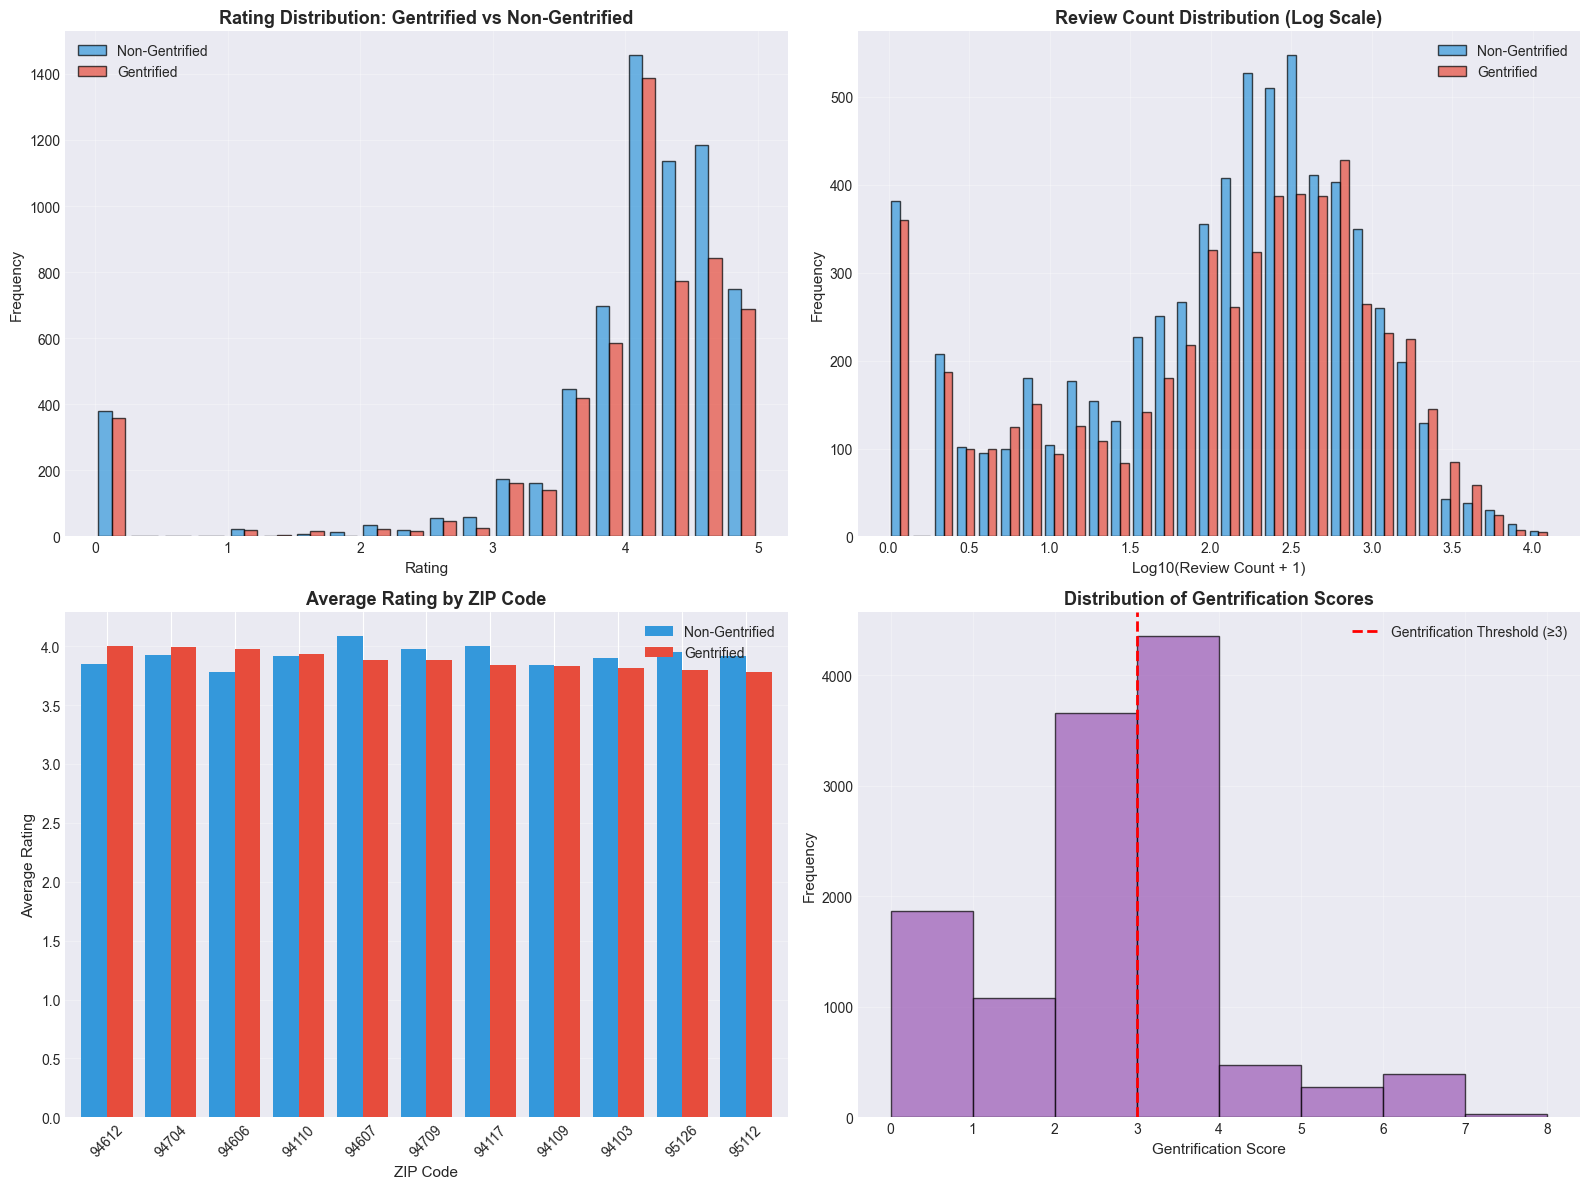


Rating Statistics:
Gentrified businesses - Mean: 3.88, Median: 4.10
Non-gentrified businesses - Mean: 3.92, Median: 4.20

Review Count Statistics:
Gentrified businesses - Mean: 511, Median: 191
Non-gentrified businesses - Mean: 434, Median: 166


In [44]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Rating distribution
gentrified_ratings = df[df['is_gentrified'] == True]['rating'].dropna()
non_gentrified_ratings = df[df['is_gentrified'] == False]['rating'].dropna()

axes[0, 0].hist([non_gentrified_ratings, gentrified_ratings], 
                bins=20, alpha=0.7, label=['Non-Gentrified', 'Gentrified'],
                color=['#3498db', '#e74c3c'], edgecolor='black')
axes[0, 0].set_title('Rating Distribution: Gentrified vs Non-Gentrified', 
                      fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Rating', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Review count distribution (log scale)
gentrified_reviews = df[df['is_gentrified'] == True]['review_count'].dropna()
non_gentrified_reviews = df[df['is_gentrified'] == False]['review_count'].dropna()

axes[0, 1].hist([np.log10(non_gentrified_reviews + 1), np.log10(gentrified_reviews + 1)], 
                bins=30, alpha=0.7, label=['Non-Gentrified', 'Gentrified'],
                color=['#3498db', '#e74c3c'], edgecolor='black')
axes[0, 1].set_title('Review Count Distribution (Log Scale)', 
                      fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Log10(Review Count + 1)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Average rating by ZIP (gentrified vs non-gentrified)
rating_by_zip = df.groupby(['zip', 'is_gentrified'])['rating'].mean().unstack(fill_value=0)
rating_by_zip.columns = ['Non-Gentrified', 'Gentrified']
rating_by_zip = rating_by_zip.sort_values('Gentrified', ascending=False)

ax3 = rating_by_zip.plot(kind='bar', ax=axes[1, 0], color=['#3498db', '#e74c3c'], width=0.8)
axes[1, 0].set_title('Average Rating by ZIP Code', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('ZIP Code', fontsize=11)
axes[1, 0].set_ylabel('Average Rating', fontsize=11)
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Gentrification score distribution
axes[1, 1].hist(df['gentrification_score'], bins=range(0, df['gentrification_score'].max()+2), 
                alpha=0.7, color='#9b59b6', edgecolor='black')
axes[1, 1].axvline(x=3, color='red', linestyle='--', linewidth=2, 
                   label='Gentrification Threshold (≥3)')
axes[1, 1].set_title('Distribution of Gentrification Scores', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Gentrification Score', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rating_review_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRating Statistics:")
print(f"Gentrified businesses - Mean: {gentrified_ratings.mean():.2f}, Median: {gentrified_ratings.median():.2f}")
print(f"Non-gentrified businesses - Mean: {non_gentrified_ratings.mean():.2f}, Median: {non_gentrified_ratings.median():.2f}")

print("\nReview Count Statistics:")
print(f"Gentrified businesses - Mean: {gentrified_reviews.mean():.0f}, Median: {gentrified_reviews.median():.0f}")
print(f"Non-gentrified businesses - Mean: {non_gentrified_reviews.mean():.0f}, Median: {non_gentrified_reviews.median():.0f}")


In [45]:
# ================================
#  SUMMARY STATISTICS AND INSIGHTS
# ================================

print("=" * 70)
print("GENTRIFICATION ANALYSIS SUMMARY")
print("=" * 70)

print(f"\n📊 OVERALL STATISTICS:")
print(f"   Total Businesses Analyzed: {len(df):,}")
print(f"   Gentrified Businesses: {df['is_gentrified'].sum():,} ({df['is_gentrified'].mean()*100:.1f}%)")
print(f"   Non-Gentrified Businesses: {(~df['is_gentrified']).sum():,} ({(~df['is_gentrified']).mean()*100:.1f}%)")

print(f"\n🏆 TOP GENTRIFYING ZIP CODES (by percentage):")
top_gentrifying = zip_stats.sort_values('gentrified_pct', ascending=False).head(5)
for zip_code, row in top_gentrifying.iterrows():
    city = row.get('city', 'Unknown')
    print(f"   {zip_code} ({city}): {row['gentrified_pct']*100:.1f}% gentrified "
          f"({int(row['gentrified_count'])}/{int(row['total_businesses'])} businesses)")

print(f"\n💰 PRICE TIER ANALYSIS:")
gentrified_price = df[df['is_gentrified'] == True]['price'].value_counts()
non_gentrified_price = df[df['is_gentrified'] == False]['price'].value_counts()
print(f"   Gentrified businesses:")
for price, count in gentrified_price.items():
    if pd.notna(price):
        print(f"      {price}: {count:,} businesses")
print(f"   Non-gentrified businesses:")
for price, count in non_gentrified_price.head(5).items():
    if pd.notna(price):
        print(f"      {price}: {count:,} businesses")

print(f"\n⭐ RATING ANALYSIS:")
print(f"   Gentrified - Mean: {df[df['is_gentrified']==True]['rating'].mean():.2f}, "
      f"Median: {df[df['is_gentrified']==True]['rating'].median():.2f}")
print(f"   Non-Gentrified - Mean: {df[df['is_gentrified']==False]['rating'].mean():.2f}, "
      f"Median: {df[df['is_gentrified']==False]['rating'].median():.2f}")

print(f"\n📈 GENTRIFICATION SCORE DISTRIBUTION:")
print(f"   Mean Score: {df['gentrification_score'].mean():.2f}")
print(f"   Median Score: {df['gentrification_score'].median():.2f}")
print(f"   Max Score: {df['gentrification_score'].max()}")
print(f"   Businesses with score ≥ 3 (gentrified): {df[df['gentrification_score'] >= 3].shape[0]:,}")
print(f"   Businesses with score ≥ 5 (highly gentrified): {df[df['gentrification_score'] >= 5].shape[0]:,}")

print(f"\n🎯 KEY INSIGHTS:")
print(f"   1. {df['is_gentrified'].mean()*100:.1f}% of businesses show gentrification indicators")
print(f"   2. High price tiers ($$$ and $$$$) are strong indicators of gentrification")
print(f"   3. Trendy categories like 'New American', 'Cocktail Bars', and 'Vegan' are common")
print(f"   4. Gentrified businesses tend to have higher average ratings")

print("\n" + "=" * 70)


GENTRIFICATION ANALYSIS SUMMARY

📊 OVERALL STATISTICS:
   Total Businesses Analyzed: 12,123
   Gentrified Businesses: 5,519 (45.5%)
   Non-Gentrified Businesses: 6,604 (54.5%)

🏆 TOP GENTRIFYING ZIP CODES (by percentage):
   94117 (nan): 59.0% gentrified (749/1262 businesses)
   94110 (nan): 56.0% gentrified (527/938 businesses)
   94709 (nan): 52.0% gentrified (342/652 businesses)
   94103 (nan): 45.0% gentrified (604/1344 businesses)
   94612 (nan): 45.0% gentrified (497/1110 businesses)

💰 PRICE TIER ANALYSIS:
   Gentrified businesses:
      $$: 2,408 businesses
      $$$: 651 businesses
      $: 318 businesses
      $$$$: 232 businesses
   Non-gentrified businesses:
      $$: 3,246 businesses
      $: 1,233 businesses

⭐ RATING ANALYSIS:
   Gentrified - Mean: 3.88, Median: 4.10
   Non-Gentrified - Mean: 3.92, Median: 4.20

📈 GENTRIFICATION SCORE DISTRIBUTION:
   Mean Score: 2.25
   Median Score: 2.00
   Max Score: 7
   Businesses with score ≥ 3 (gentrified): 5,519
   Businesses wit

In [46]:
# ================================
#  EXPORT RESULTS FOR MODELING
# ================================

# Save the dataframe with gentrification labels
df.to_csv('bay_area_yelp_businesses_with_labels.csv', index=False)
print("✅ Saved labeled dataset to 'bay_area_yelp_businesses_with_labels.csv'")

# Create ZIP-level summary for neighborhood classification
zip_summary = df.groupby('zip').agg({
    'is_gentrified': ['sum', 'mean', 'count'],
    'gentrification_score': 'mean',
    'price': lambda x: (x.isin(['$$$', '$$$$']).sum() / len(x) if len(x) > 0 else 0),
    'rating': 'mean',
    'review_count': 'mean'
}).round(3)

zip_summary.columns = ['gentrified_count', 'gentrified_pct', 'total_businesses', 
                        'avg_gentrification_score', 'high_price_pct', 
                        'avg_rating', 'avg_review_count']
zip_summary = zip_summary.reset_index()
zip_summary['city'] = zip_summary['zip'].map(city_labels)

zip_summary.to_csv('zip_code_gentrification_summary.csv', index=False)
print("Saved ZIP code summary to 'zip_code_gentrification_summary.csv'")

print("\n Files created:")
print("   - bay_area_yelp_businesses_with_labels.csv (full dataset with labels)")
print("   - zip_code_gentrification_summary.csv (ZIP-level features for classification)")
print("   - gentrification_by_zip.png")
print("   - price_tier_analysis.png")
print("   - category_analysis.png")
print("   - rating_review_analysis.png")
if df['lat'].notna().sum() > 0:
    print("   - geographic_distribution.png")

zip_summary.head(10)


✅ Saved labeled dataset to 'bay_area_yelp_businesses_with_labels.csv'
Saved ZIP code summary to 'zip_code_gentrification_summary.csv'

 Files created:
   - bay_area_yelp_businesses_with_labels.csv (full dataset with labels)
   - zip_code_gentrification_summary.csv (ZIP-level features for classification)
   - gentrification_by_zip.png
   - price_tier_analysis.png
   - category_analysis.png
   - rating_review_analysis.png
   - geographic_distribution.png


,zip,gentrified_count,gentrified_pct,total_businesses,avg_gentrification_score,high_price_pct,avg_rating,avg_review_count,city
0,94103,604,0.449,1344,2.380,0.143,3.863,610.420,NaN
1,94109,521,0.432,1207,2.392,0.147,3.839,618.268,NaN
2,94110,527,0.562,938,2.518,0.075,3.926,494.936,NaN
3,94117,749,0.594,1262,2.735,0.130,3.907,552.729,NaN
4,94606,464,0.441,1051,2.112,0.032,3.867,321.365,NaN
5,94607,594,0.417,1426,2.097,0.053,4.002,379.842,NaN
6,94612,497,0.448,1110,2.124,0.032,3.915,332.959,NaN
7,94704,277,0.334,830,1.978,0.028,3.946,395.960,NaN
8,94709,342,0.525,652,2.255,0.017,3.930,373.945,NaN
9,95112,444,0.397,1119,2.009,0.044,3.863,490.925,NaN
